In [1]:
import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from datasets import load_dataset

In [3]:
# Define a BERT configuration for training from scratch
config = BertConfig(
    vocab_size=30522,  # Standard BERT vocabulary size
    hidden_size=768,   # Embedding dimension
    num_hidden_layers=12,  # Number of transformer blocks
    num_attention_heads=12, # Number of attention heads per block
    intermediate_size=3072, # Feedforward layer dimension
    num_labels=2            # For binary classification (positive/negative)
)

# Initialize an untrained BERT model for sequence classification
model = BertForSequenceClassification(config)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [4]:
# Load the IMDb dataset
dataset = load_dataset("imdb")

# Split the dataset into training and test sets
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Display the structure of the dataset
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})


In [7]:
# Define a function to tokenize the input texts with max_length set to 256
def preprocess_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

# Apply the tokenizer to the entire dataset
encoded_train_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_test_dataset = test_dataset.map(preprocess_function, batched=True)

# Remove the text column since it's no longer needed after tokenization
encoded_train_dataset = encoded_train_dataset.remove_columns(["text"])
encoded_test_dataset = encoded_test_dataset.remove_columns(["text"])

# Set the format to PyTorch tensors
encoded_train_dataset.set_format("torch")
encoded_test_dataset.set_format("torch")

# Display the structure of the processed datasets
print(encoded_train_dataset)
print(encoded_test_dataset)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})
Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})


In [8]:
from torch.utils.data import DataLoader

# Define the batch size
batch_size = 16

# Create data loaders for training and testing
train_dataloader = DataLoader(encoded_train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(encoded_test_dataset, batch_size=batch_size)

# Display an example batch to confirm everything is working
for batch in train_dataloader:
    print(batch)
    break  # Print only the first batch for verification


{'label': tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]), 'input_ids': tensor([[ 101, 3564, 2091,  ..., 3014, 1010,  102],
        [ 101, 1996, 2627,  ...,    0,    0,    0],
        [ 101, 1045, 2179,  ...,    0,    0,    0],
        ...,
        [ 101, 2023, 2001,  ...,    0,    0,    0],
        [ 101, 2023, 2003,  ...,    0,    0,    0],
        [ 101, 1045, 3427,  ..., 1996, 3663,  102]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]])}


In [9]:
from torch.optim import AdamW
import torch.nn as nn

# Define the optimizer - AdamW with weight decay
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define the loss function - CrossEntropyLoss for binary classification
loss_fn = nn.CrossEntropyLoss()


In [13]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop with model on the appropriate device
model.train()  # Set the model to training mode

epochs = 3
loss_values = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0
    
    for batch in train_dataloader:
        # Move batch data to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Clear previously calculated gradients
        optimizer.zero_grad()

        # Perform a forward pass and compute the loss
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['label'])
        loss = outputs.loss

        # Backpropagate to compute gradients
        loss.backward()

        # Update parameters with optimizer
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()
    
    # Store average loss for this epoch
    avg_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_loss)
    print(f"Average loss for epoch {epoch + 1}: {avg_loss}")


Epoch 1/3
Average loss for epoch 1: 0.708169736277958
Epoch 2/3
Average loss for epoch 2: 0.7039172646714111
Epoch 3/3
Average loss for epoch 3: 0.7017565330708553


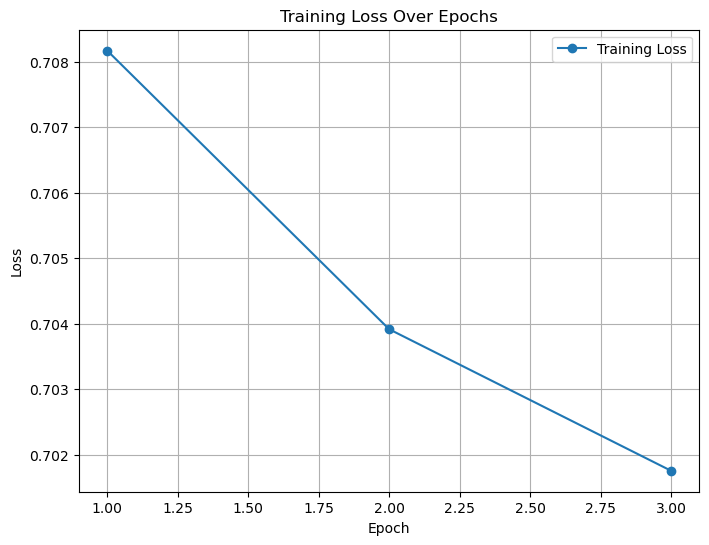

In [14]:
import matplotlib.pyplot as plt

# Plot the loss values over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Save the model
model.save_pretrained('sentiment-analysis-bert')

# Save the tokenizer
tokenizer.save_pretrained('sentiment-analysis-bert')

print("Model and tokenizer saved successfully!")


In [17]:
# Set the model to evaluation mode
model.eval()

# Tracking variables
correct_predictions = 0
total_predictions = 0

# Disable gradient calculations for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Move batch data to the same device as the model
        batch = {k: v.to(device) for k, v in batch.items()}

        # Perform a forward pass and get logits
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        logits = outputs.logits

        # Get the predicted class (the index with the highest logit score)
        predictions = torch.argmax(logits, dim=-1)

        # Count correct predictions by comparing with true labels
        correct_predictions += (predictions == batch['label']).sum().item()
        total_predictions += batch['label'].size(0)

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f'Accuracy on the test set: {accuracy * 100:.2f}%')


Accuracy on the test set: 50.00%
